<a href="https://colab.research.google.com/github/Amir-Subaih/amir/blob/master/Segmentation_And_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-docx
!pip install pdfplumber
!pip install networkx
!pip install matplotlib
!pip install nltk
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 38.5 MB/s eta 0:00:00


In [ ]:
import docx
import pdfplumber
import re
import networkx as nx
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Summary:
Amir Subaih is pursuing a Bachelor's degree in Computer Science at Arab American University. With practical skills in various programming languages and hands-on experience in web development, I am eager to contribute to innovative projects.
Segmented CV Text:
{'Overview': {'About Me': 'About Me'}, 'Academic Qualifications': {'University': 'Computer Science Arab American University 2020-2024', 'Education': 'Education'}, 'Contact': {'Contact': 'Contact\nPhon :+972597159634', 'Email': 'Email : amirsubaih@gmail.com', 'Location': 'Location :Aqba village / Tubas City\nLinkedin : Amir Subaih'}, 'Abilities': {'Skills': 'Skills\nAI, Python, Data Science'}}
Summary of CV and Job Post Keyword Comparison:

 Overview - Summary:
CV:


Job Post:
Looking for a proactive and experienced software engineer with strong skills in web development.

Percentage Match: 0.0%

 Abilities - Skills:
CV:
Skills
AI, Python, Data Science

Job Post:
Proficient in Python, React, and AWS.

Percentage Match: 1

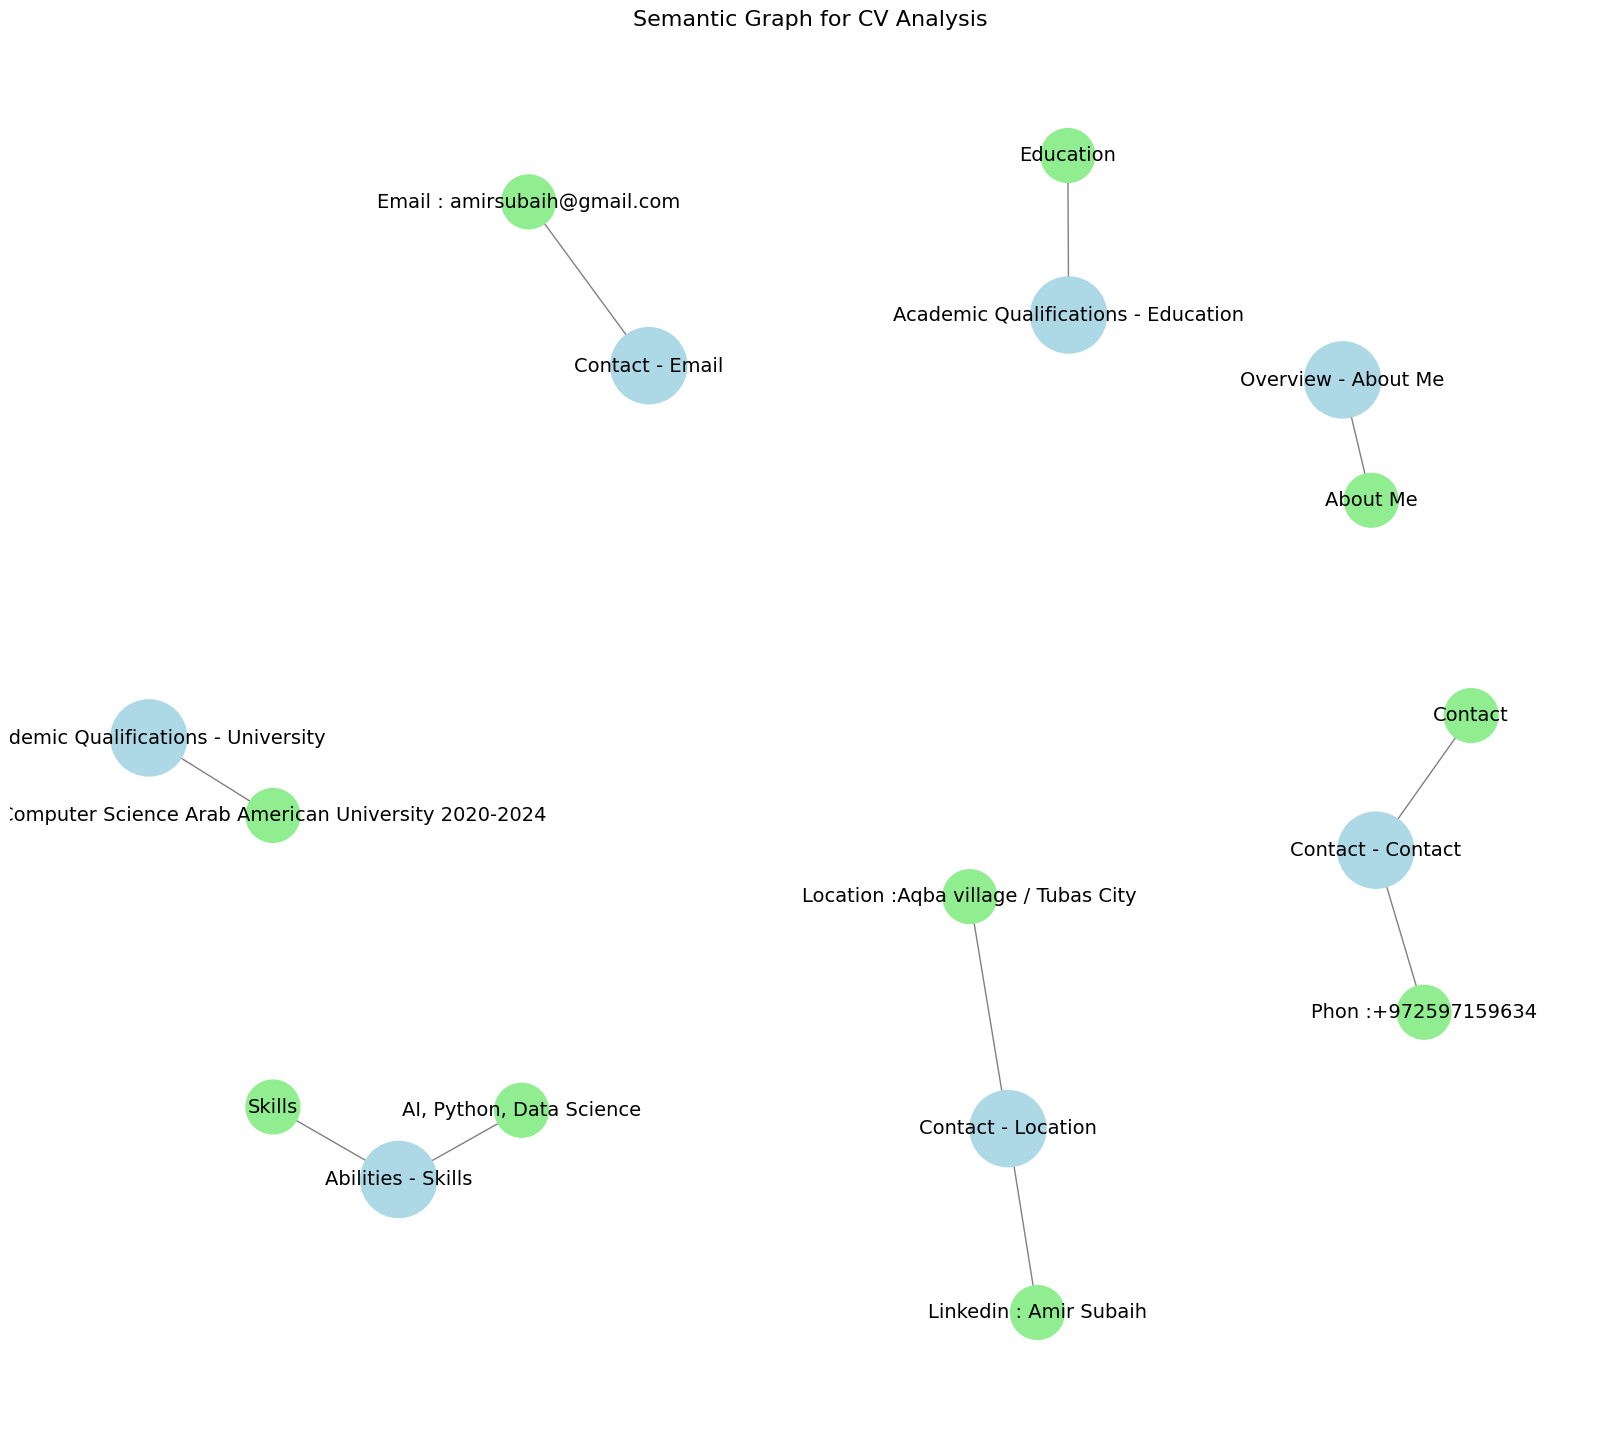

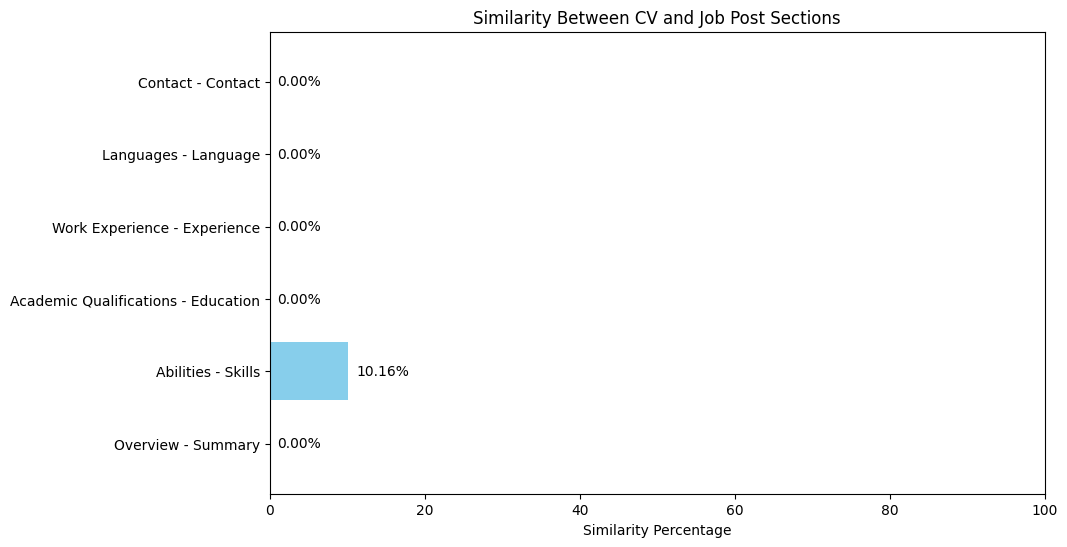

In [ ]:
# Define headers for each section category
headers = {
    "Overview": ["About Me", "Personal Statement", "Profile", "Summary"],
    "Abilities": ["Skills", "Expertise", "Competencies"],
    "Academic Qualifications": ["Education", "Degree", "University", "GPA", "Qualification"],
    "Work Experience": ["Experience", "Job", "Role", "Responsibilities", "Company"],
    "Publications": ["Publication", "Research", "Paper", "Article", "Conference"],
    "Languages": ["Language", "Arabic", "English", "Fluent", "Proficient"],
    "Contact": ["Contact", "Phone", "Email", "Address", "Location"]
}

# Function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    text = ""
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ""  # Handle case where text might be None
    return text

# Function to extract text from a DOCX file
def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    text = "\n".join([para.text for para in doc.paragraphs if para.text.strip()])  # Exclude empty paragraphs
    return text

# Function to extract text from tables in DOCX and PDF
def extract_text_from_tables(file_path):
    table_texts = []
    if file_path.endswith('.pdf'):
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                for table in page.extract_tables():
                    for row in table:
                        table_texts.append(' | '.join(str(cell) for cell in row))
    elif file_path.endswith('.docx'):
        doc = docx.Document(file_path)
        for table in doc.tables:
            for row in table.rows:
                table_texts.append(' | '.join(cell.text.strip() for cell in row.cells))
    return '\n'.join(table_texts)

# Function to summarize text
def summarize_text(text):
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    summary = summarizer(text, max_length=150, min_length=30, do_sample=False)
    return summary[0]['summary_text']

# Function to extract keywords from text
def extract_keywords(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = word_tokenize(text.lower())
    filtered_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]

    freq_dist = nltk.FreqDist(filtered_words)
    keywords = [word for word, _ in freq_dist.most_common(10)]
    return keywords

# Function to improve segmentation with new headers
def segment_text(text):
    segments = {}
    current_category = None
    current_header = None
    segment_text = ""

    lines = text.split('\n')
    for line in lines:
        header_found = False

        # Check if the line matches any header in the categories
        for category, header_list in headers.items():
            for header in header_list:
                if header in line:
                    header_found = True
                    if current_header:
                        # Save the current segment text under the current header
                        if current_category not in segments:
                            segments[current_category] = {}
                        segments[current_category][current_header] = segment_text.strip()

                    # Update the current header and category
                    current_header = header
                    current_category = category
                    segment_text = ""
                    break
            if header_found:
                break

        segment_text += line + "\n"

    if current_header:
        if current_category not in segments:
            segments[current_category] = {}
        segments[current_category][current_header] = segment_text.strip()

    return segments

# Function to calculate similarity percentage using TF-IDF and cosine similarity
def similarity_percentage(a, b):
    vectorizer = TfidfVectorizer().fit_transform([a, b])
    vectors = vectorizer.toarray()
    return cosine_similarity([vectors[0]], [vectors[1]])[0][0] * 100

# Function to compare keywords from job post with CV sections
def compare_keywords_with_cv(cv_segments, job_post_keywords):
    comparison_summary = {}

    for category, headers_dict in job_post_keywords.items():
        for header, job_post_text in headers_dict.items():
            cv_text = cv_segments.get(category, {}).get(header, "")
            # Calculate similarity percentage
            percentage = similarity_percentage(cv_text, job_post_text)

            # Add to the summary
            comparison_summary[f"{category} - {header}"] = {
                "CV": cv_text.strip(),
                "Job Post": job_post_text.strip(),
                "Percentage Match": round(percentage, 2)  # Rounded to two decimal places
            }

    return comparison_summary

# Function to summarize the comparison
def summarize_comparison(comparison_summary):
    summary = "Summary of CV and Job Post Keyword Comparison:\n\n"
    for keyword, content in comparison_summary.items():
        summary += f" {keyword}:\n"
        summary += f"CV:\n{content['CV']}\n\n"
        summary += f"Job Post:\n{content['Job Post']}\n\n"
        summary += f"Percentage Match: {content['Percentage Match']}%\n\n"

    return summary

# Function to create a semantic graph
def create_semantic_graph(categorized_segments, title):
    graph = nx.Graph()  # Create a new undirected graph

    # Add main keywords (nodes) and their details
    for category, headers_dict in categorized_segments.items():
        for header, content in headers_dict.items():
            # Add the main node
            main_node = f"{category} - {header}"
            graph.add_node(main_node, type='main', label=main_node)

            # Add detailed nodes and edges
            for detail in content.split('\n'):
                if detail.strip():  # Add non-empty details as nodes
                    detail_node = f"{main_node} - {detail[:30]}..."  # Shorten the detail text for node labeling
                    graph.add_node(detail_node, type='detail', label=detail.strip())
                    graph.add_edge(main_node, detail_node)  # Connect main keyword to the detail

    # Visualize the graph
    pos = nx.spring_layout(graph, k=0.5, iterations=50)  # Use spring layout with adjusted parameters
    node_types = nx.get_node_attributes(graph, 'type')
    labels = nx.get_node_attributes(graph, 'label')

    color_map = {'main': 'lightblue', 'detail': 'lightgreen'}
    node_colors = [color_map[node_types.get(node, 'main')] for node in graph.nodes()]
    node_sizes = [3000 if node_types.get(node) == 'main' else 1500 for node in graph.nodes()]
    font_sizes = [14 if node_types.get(node) == 'main' else 12 for node in graph.nodes()]

    plt.figure(figsize=(16, 14))  # Increase figure size for better visibility
    nx.draw(graph, pos, with_labels=True, labels=labels, node_color=node_colors, edge_color='gray', node_size=node_sizes, font_size=14, font_color='black')
    plt.title(f'Semantic Graph for {title}', fontsize=16)
    plt.show()

    return graph

# Function to plot similarity percentages as a bar chart
def plot_similarity_chart(comparison_summary):
    categories = list(comparison_summary.keys())
    percentages = [content["Percentage Match"] for content in comparison_summary.values()]

    plt.figure(figsize=(10, 6))
    plt.barh(categories, percentages, color='skyblue')
    plt.xlabel('Similarity Percentage')
    plt.title('Similarity Between CV and Job Post Sections')
    plt.xlim(0, 100)

    for index, value in enumerate(percentages):
        plt.text(value + 1, index, f'{value:.2f}%', va='center', fontsize=10)

    plt.show()

# Main function to process the file and compare with job post keywords
def process_file_and_compare_with_job_post_keywords(file_path, job_post_keywords):
    # Determine file type
    if file_path.endswith('.pdf'):
        text = extract_text_from_pdf(file_path)
    elif file_path.endswith('.docx'):
        text = extract_text_from_docx(file_path)
    else:
        raise ValueError("Unsupported file format. Please provide a PDF or DOCX file.")

    # Extract text from tables
    table_texts = extract_text_from_tables(file_path)
    text += "\n" + table_texts  # Append table text to main text

    # Summarize the text
    summary = summarize_text(text)
    print("Summary:")
    print(summary)

    # Segment the text
    cv_segments = segment_text(text)
    print("Segmented CV Text:")
    print(cv_segments)

    # Compare job post keywords with CV segments
    comparison_summary = compare_keywords_with_cv(cv_segments, job_post_keywords)
    summary = summarize_comparison(comparison_summary)
    print(summary)

    # Create and display the semantic graph
    graph = create_semantic_graph(cv_segments, "CV Analysis")

    # Plot similarity chart
    plot_similarity_chart(comparison_summary)

    return comparison_summary, graph

# Example job post keywords dictionary
job_post_keywords = {
    "Overview": {"Summary": "Looking for a proactive and experienced software engineer with strong skills in web development."},
    "Abilities": {"Skills": "Proficient in Python, React, and AWS."},
    "Academic Qualifications": {"Education": "Bachelor's degree in Computer Science."},
    "Work Experience": {"Experience": "3+ years of experience in software development."},
    "Languages": {"Language": "Fluent in English and Arabic."},
    "Contact": {"Contact": "Email: example@domain.com"}
}

# Example usage
file_path = "CV11.docx"
comparison_summary, graph = process_file_and_compare_with_job_post_keywords(file_path, job_post_keywords)

The Code 2

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Summary:
Sanad Ahmad is an IT Project Manager and AI Trainer. He is based in Jaba' – Jenin – Palestine. He has worked in Dubai, Palestine, and Saudi Arabia.
Summary of CV and Job Post Keyword Comparison:

 Overview:
CV:


Job Post:
Living in Nablus, with 5 years of experience in web development.

Percentage Match: 0.0%

 Abilities:
CV:


Job Post:
AI, Python, Data Science

Percentage Match: 0.0%

 Academic Qualifications:
CV:
** Academic Qualifications

Job Post:
Bachelor's degree in Computer Science from Arab American University.

Percentage Match: 0.0%

 Publications:
CV:
** Publications
NLU-STR at SemEval-2024 Task 1: Generative-based Augmentation and Encoder-based Scoring for Semantic Textual Relatedness
Context-Gloss Augmentation for Improving Arabic Target Sense Verification
Salma: Arabic sense-annotated corpus and wsd benchmarks
Classification and Prediction of Low-Density Lipoprotein Cholesterol LDL-C …
Detecting Network Traffic-based Attacks Using ANNs

Job Post:
No public

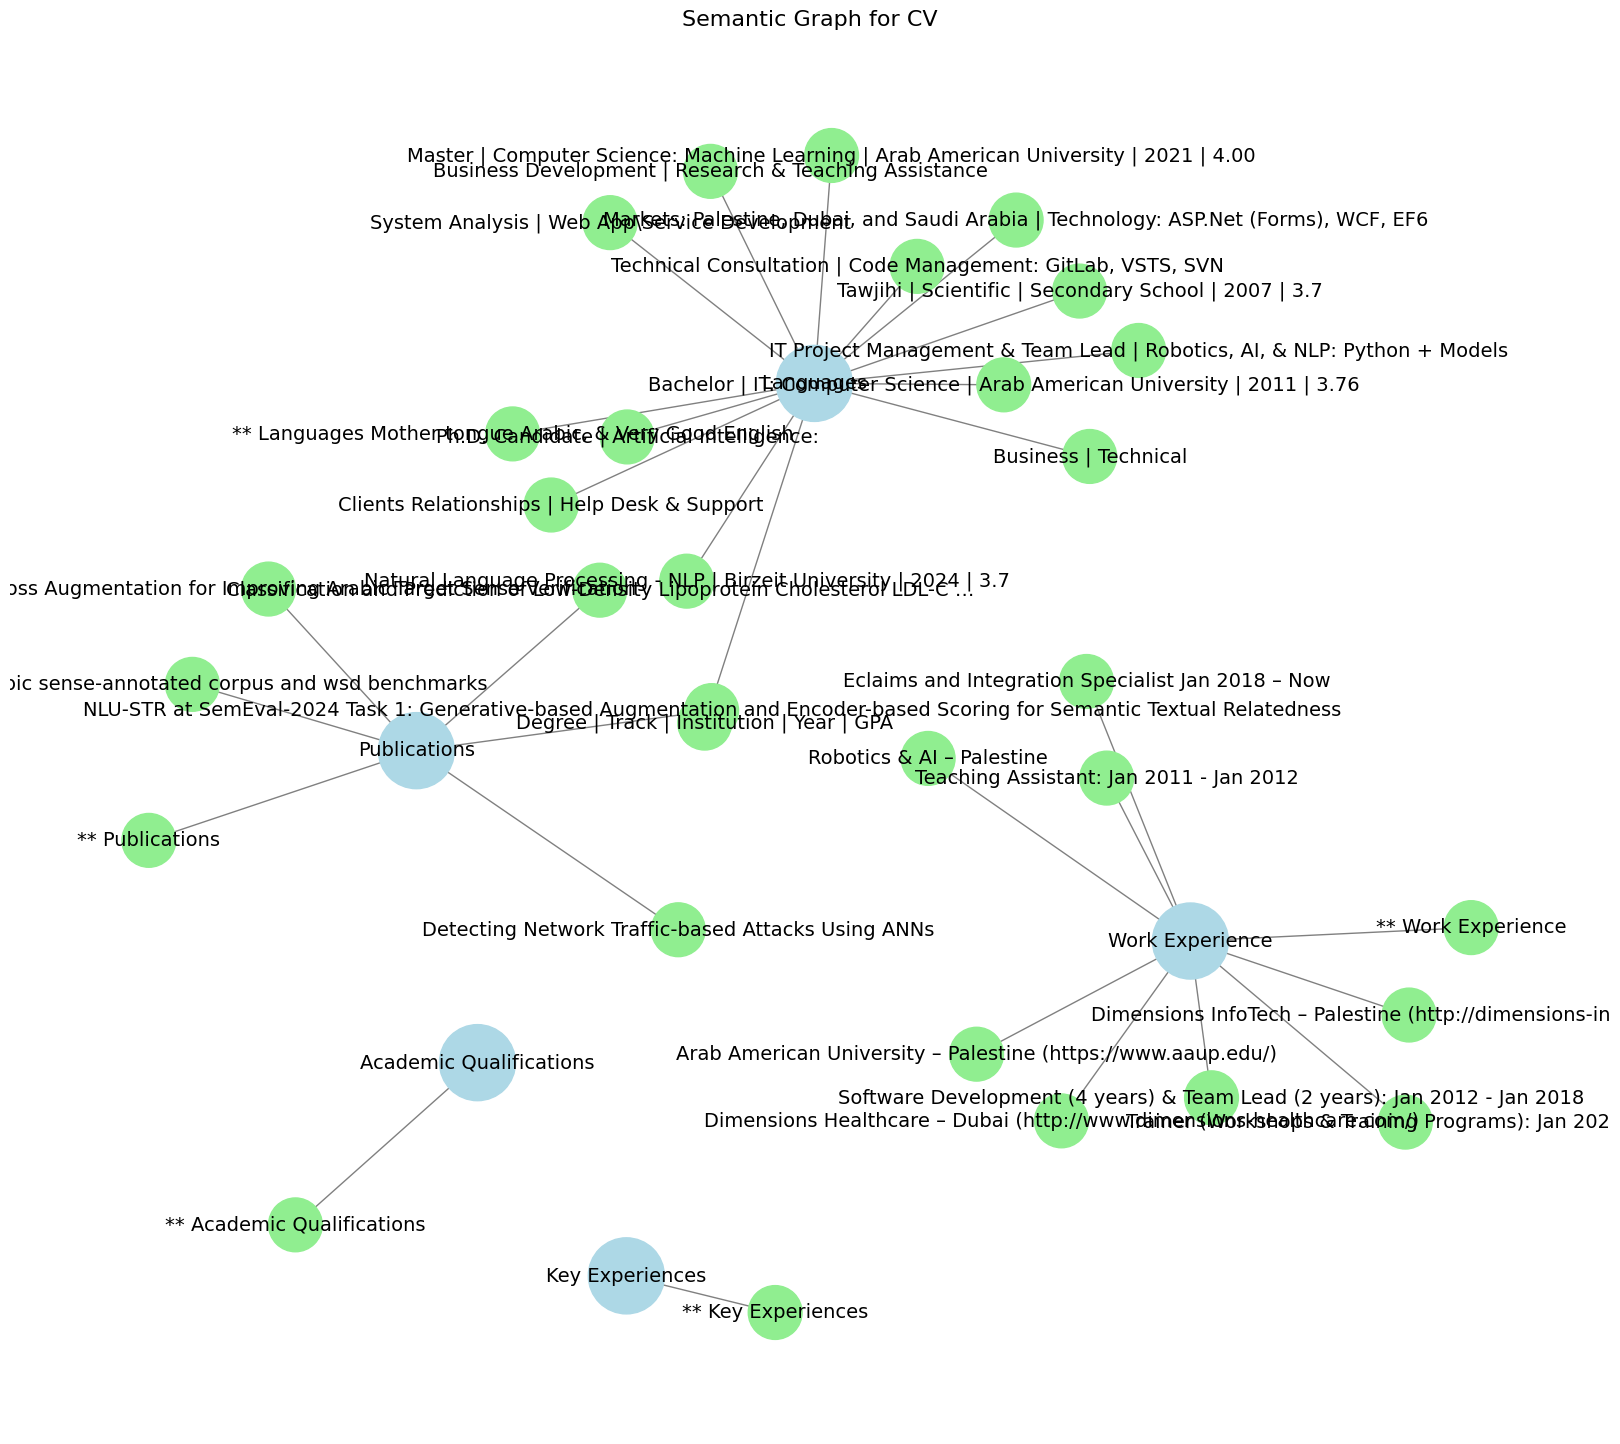

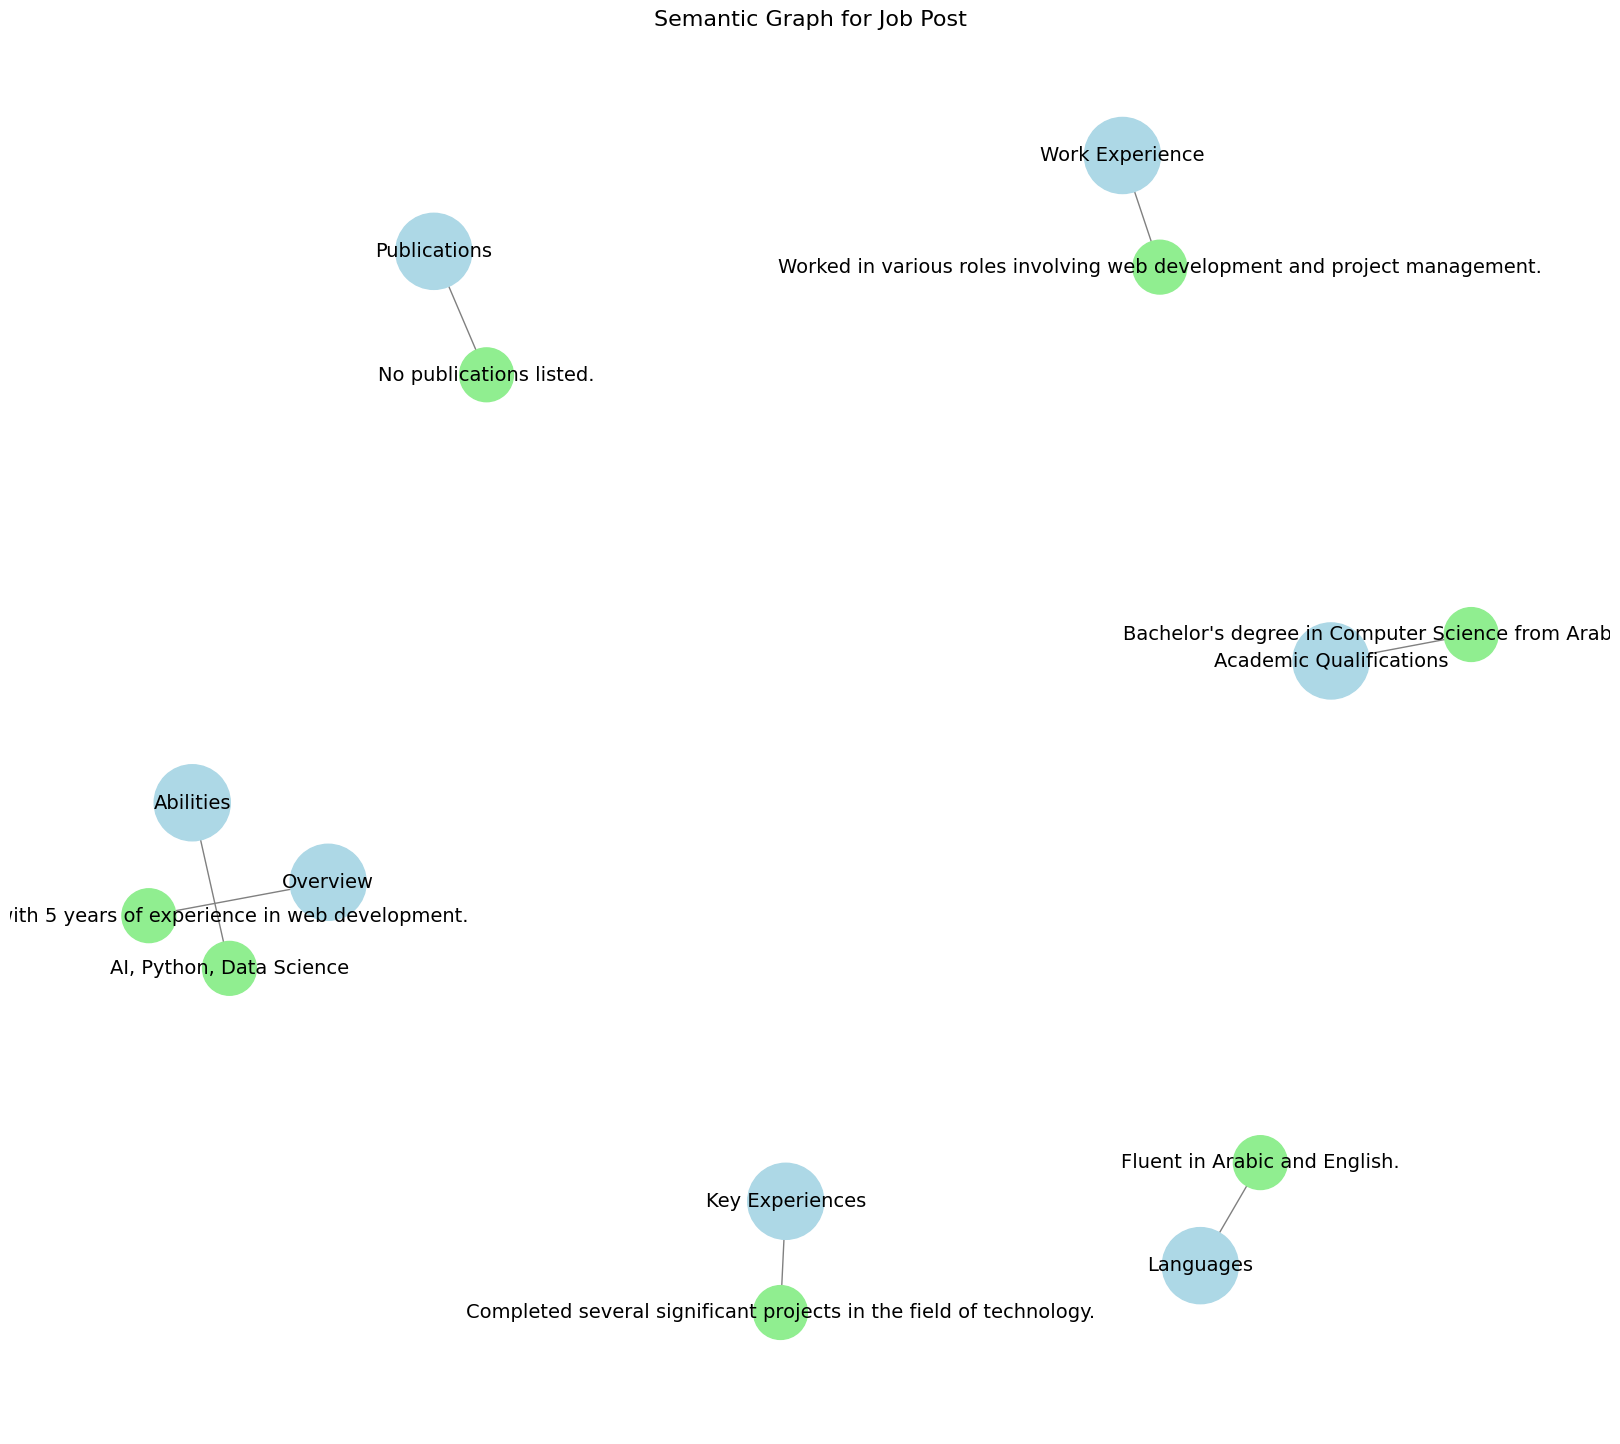

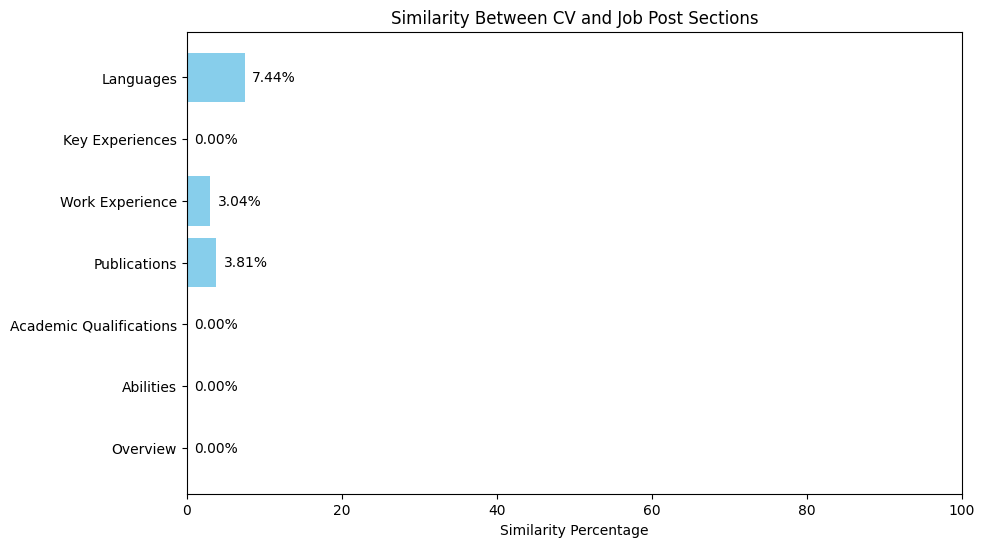

In [ ]:
# Define keywords for each section with new header categories
keywords = {
    "Overview": ["About Me", "Personal Statement", "Profile", "Summary"],
    "Abilities": ["Skills", "Expertise", "Competencies"],
    "Academic Qualifications": ["degree", "university", "GPA", "qualification", "education"],
    "Publications": ["publication", "research", "paper", "article", "conference"],
    "Work Experience": ["experience", "job", "role", "responsibility", "company"],
    "Key Experiences": ["skills", "experience", "projects", "achievements"],
    "Languages": ["language", "Arabic", "English", "fluent", "proficient"],
}

# Function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    text = ""
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() or ""  # Handle case where text might be None
    return text

# Function to extract text from a DOCX file
def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    text = "\n".join([para.text for para in doc.paragraphs if para.text.strip()])  # Exclude empty paragraphs
    return text

# Function to extract text from tables in DOCX and PDF
def extract_text_from_tables(file_path):
    table_texts = []
    if file_path.endswith('.pdf'):
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                for table in page.extract_tables():
                    for row in table:
                        table_texts.append(' | '.join(str(cell) for cell in row))
    elif file_path.endswith('.docx'):
        doc = docx.Document(file_path)
        for table in doc.tables:
            for row in table.rows:
                table_texts.append(' | '.join(cell.text.strip() for cell in row.cells))
    return '\n'.join(table_texts)

# Function to summarize text
def summarize_text(text):
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    summary = summarizer(text, max_length=150, min_length=30, do_sample=False)
    return summary[0]['summary_text']

# Function to extract keywords from text
def extract_keywords(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = word_tokenize(text.lower())
    filtered_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]

    freq_dist = nltk.FreqDist(filtered_words)
    keywords = [word for word, _ in freq_dist.most_common(10)]
    return keywords

# Function to improve segmentation
def segment_text(text, headers):
    segments = {}
    current_header = None
    segment_text = ""

    # Split by lines and also handle multiple headers
    lines = text.split('\n')
    for line in lines:
        header_found = any(header in line for header in headers)
        if header_found:
            if current_header:
                segments[current_header] = segment_text.strip()
            current_header = next(header for header in headers if header in line)
            segment_text = ""
        segment_text += line + "\n"

    if current_header:
        segments[current_header] = segment_text.strip()

    return segments

# Function to calculate similarity percentage using TF-IDF and cosine similarity
def similarity_percentage(a, b):
    vectorizer = TfidfVectorizer().fit_transform([a, b])
    vectors = vectorizer.toarray()
    return cosine_similarity([vectors[0]], [vectors[1]])[0][0] * 100

# Function to compare keywords from job post with CV sections
def compare_keywords_with_cv(cv_segments, job_post_keywords):
    comparison_summary = {}

    for category, job_post_text in job_post_keywords.items():
        cv_text = cv_segments.get(category, "")
        # Calculate similarity percentage
        percentage = similarity_percentage(cv_text, job_post_text)

        # Add to the summary
        comparison_summary[category] = {
            "CV": cv_text.strip(),
            "Job Post": job_post_text.strip(),
            "Percentage Match": round(percentage, 2)  # Rounded to two decimal places
        }

    return comparison_summary

# Function to summarize the comparison
def summarize_comparison(comparison_summary):
    summary = "Summary of CV and Job Post Keyword Comparison:\n\n"
    for category, content in comparison_summary.items():
        summary += f" {category}:\n"
        summary += f"CV:\n{content['CV']}\n\n"
        summary += f"Job Post:\n{content['Job Post']}\n\n"
        summary += f"Percentage Match: {content['Percentage Match']}%\n\n"

    return summary

# Function to create a semantic graph
def create_semantic_graph(categorized_segments, title):
    graph = nx.Graph()  # Create a new undirected graph

    # Add main keywords (nodes) and their details
    for header, content in categorized_segments.items():
        # Add the main node
        graph.add_node(header, type='main', label=header)

        # Add detailed nodes and edges
        for detail in content.split('\n'):
            if detail.strip():  # Add non-empty details as nodes
                detail_node = f"{header} - {detail[:30]}..."  # Shorten the detail text for node labeling
                graph.add_node(detail_node, type='detail', label=detail.strip())
                graph.add_edge(header, detail_node)  # Connect main keyword to the detail

    # Visualize the graph
    pos = nx.spring_layout(graph, k=0.5, iterations=50)  # Use spring layout with adjusted parameters
    node_types = nx.get_node_attributes(graph, 'type')
    labels = nx.get_node_attributes(graph, 'label')

    color_map = {'main': 'lightblue', 'detail': 'lightgreen'}
    node_colors = [color_map[node_types.get(node, 'main')] for node in graph.nodes()]
    node_sizes = [3000 if node_types.get(node) == 'main' else 1500 for node in graph.nodes()]
    font_sizes = [14 if node_types.get(node) == 'main' else 12 for node in graph.nodes()]

    plt.figure(figsize=(16, 14))  # Increase figure size for better visibility
    nx.draw(graph, pos, with_labels=True, labels=labels, node_color=node_colors, edge_color='gray', node_size=node_sizes, font_size=14, font_color='black')
    plt.title(f'Semantic Graph for {title}', fontsize=16)
    plt.show()

    return graph

# Function to plot similarity percentages as a bar chart
def plot_similarity_chart(comparison_summary):
    categories = list(comparison_summary.keys())
    percentages = [content["Percentage Match"] for content in comparison_summary.values()]

    plt.figure(figsize=(10, 6))
    plt.barh(categories, percentages, color='skyblue')
    plt.xlabel('Similarity Percentage')
    plt.title('Similarity Between CV and Job Post Sections')
    plt.xlim(0, 100)

    for index, value in enumerate(percentages):
        plt.text(value + 1, index, f'{value:.2f}%', va='center', fontsize=10)

    plt.show()

# Main function to process the file and compare with job post keywords
def process_file_and_compare_with_job_post_keywords(file_path, job_post_keywords):
    # Determine file type
    if file_path.endswith('.pdf'):
        text = extract_text_from_pdf(file_path)
    elif file_path.endswith('.docx'):
        text = extract_text_from_docx(file_path)
    else:
        raise ValueError("Unsupported file format. Please provide a PDF or DOCX file.")

    # Extract text from tables
    table_texts = extract_text_from_tables(file_path)
    text += "\n" + table_texts  # Append table text to main text

    # Summarize the text
    summary = summarize_text(text)
    print("Summary:")
    print(summary)

    # Segment the text
    headers = list(keywords.keys())
    cv_segments = segment_text(text, headers)

    # Compare job post keywords with CV sections
    comparison_summary = compare_keywords_with_cv(cv_segments, job_post_keywords)

    # Generate and print the summary
    summary_comparison = summarize_comparison(comparison_summary)
    print(summary_comparison)

    # Create and visualize the semantic graphs for CV
    create_semantic_graph(cv_segments, "CV")

    # Create and visualize the semantic graphs for Job Post
    create_semantic_graph(job_post_keywords, "Job Post")

    # Plot the similarity chart
    plot_similarity_chart(comparison_summary)

# Example job post data with new headers
job_post_keywords = {
    "Overview": "Living in Nablus, with 5 years of experience in web development.",
    "Abilities": "AI, Python, Data Science",
    "Academic Qualifications": "Bachelor's degree in Computer Science from Arab American University.",
    "Publications": "No publications listed.",
    "Work Experience": "Worked in various roles involving web development and project management.",
    "Key Experiences": "Completed several significant projects in the field of technology.",
    "Languages": "Fluent in Arabic and English."
}

# Example file path (replace with actual file path)
file_path = '/content/Sanad Ahmad - CV.docx'  # or 'path_to_your_cv.docx'

# Process the file and compare with job post keywords
process_file_and_compare_with_job_post_keywords(file_path, job_post_keywords)

Code 3

Summary:
Summary of CV and Job Post Keyword Comparison:

 Overview:
CV:


Job Post:
Living in Nablus, with 5 years of experience in web development.

Percentage Match: 10.73%

 Abilities:
CV:


Job Post:
AI, Python, Data Science

Percentage Match: 1.81%

 Academic Qualifications:
CV:
Academic Qualifications
Degree	Track	Institution	Year	GPA
Tawjihi	Scientific	Secondary School	2007	3.7
Bachelor	IT: Computer Science	Arab American University	2011	3.76
Master	Computer Science: Machine Learning	Arab American University	2021	4.00
Ph.D. Candidate	Artificial Intelligence:
Natural Language Processing - NLP	Birzeit University	2024	3.7

Job Post:
Bachelor's degree in Computer Science from Arab American University.

Percentage Match: 71.91%

 Publications:
CV:
Publications
1.	NLU-STR at SemEval-2024 Task 1: Generative-based Augmentation and Encoder-based Scoring for Semantic Textual Relatedness
2.	Context-Gloss Augmentation for Improving Arabic Target Sense Verification
3.	Salma: Arabic sense-

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


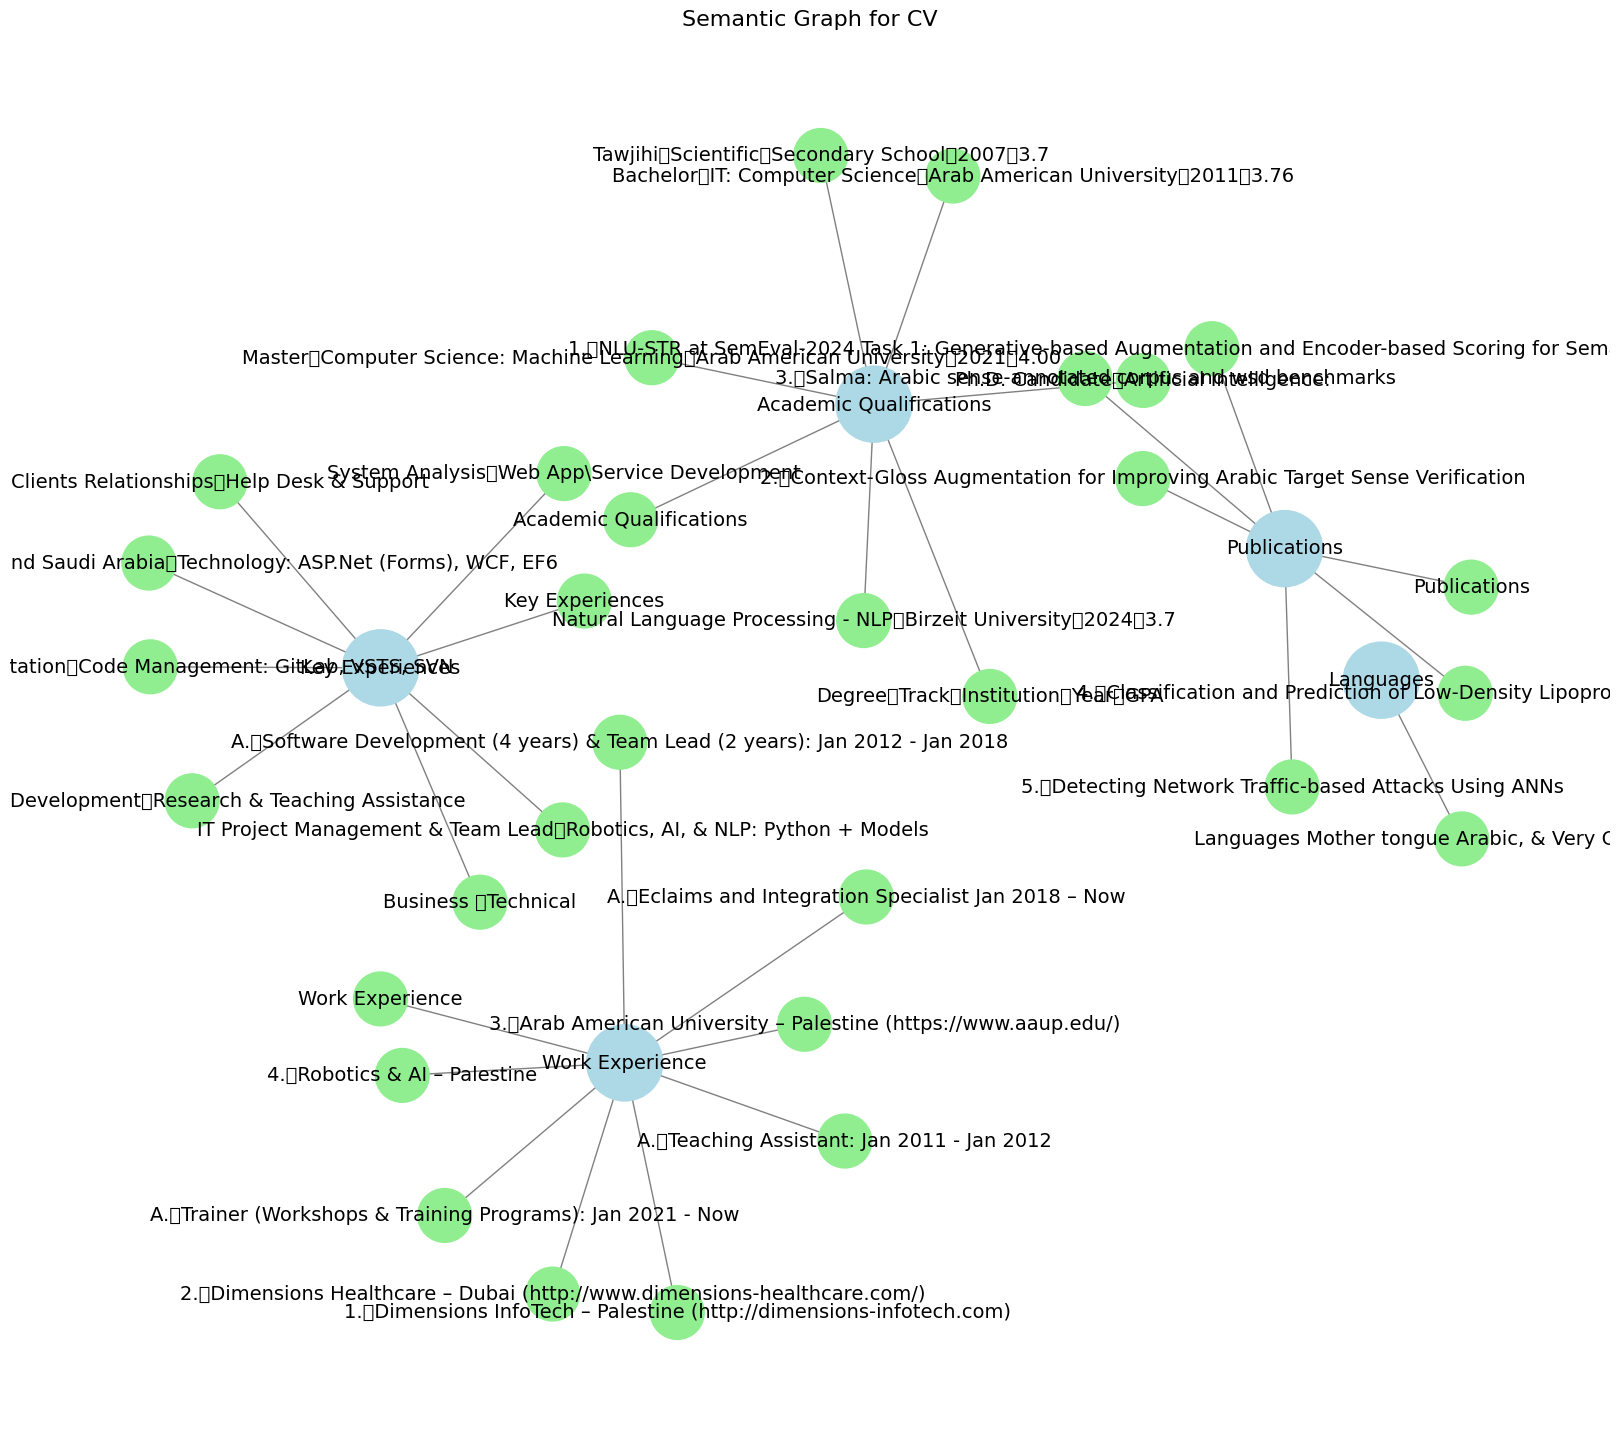

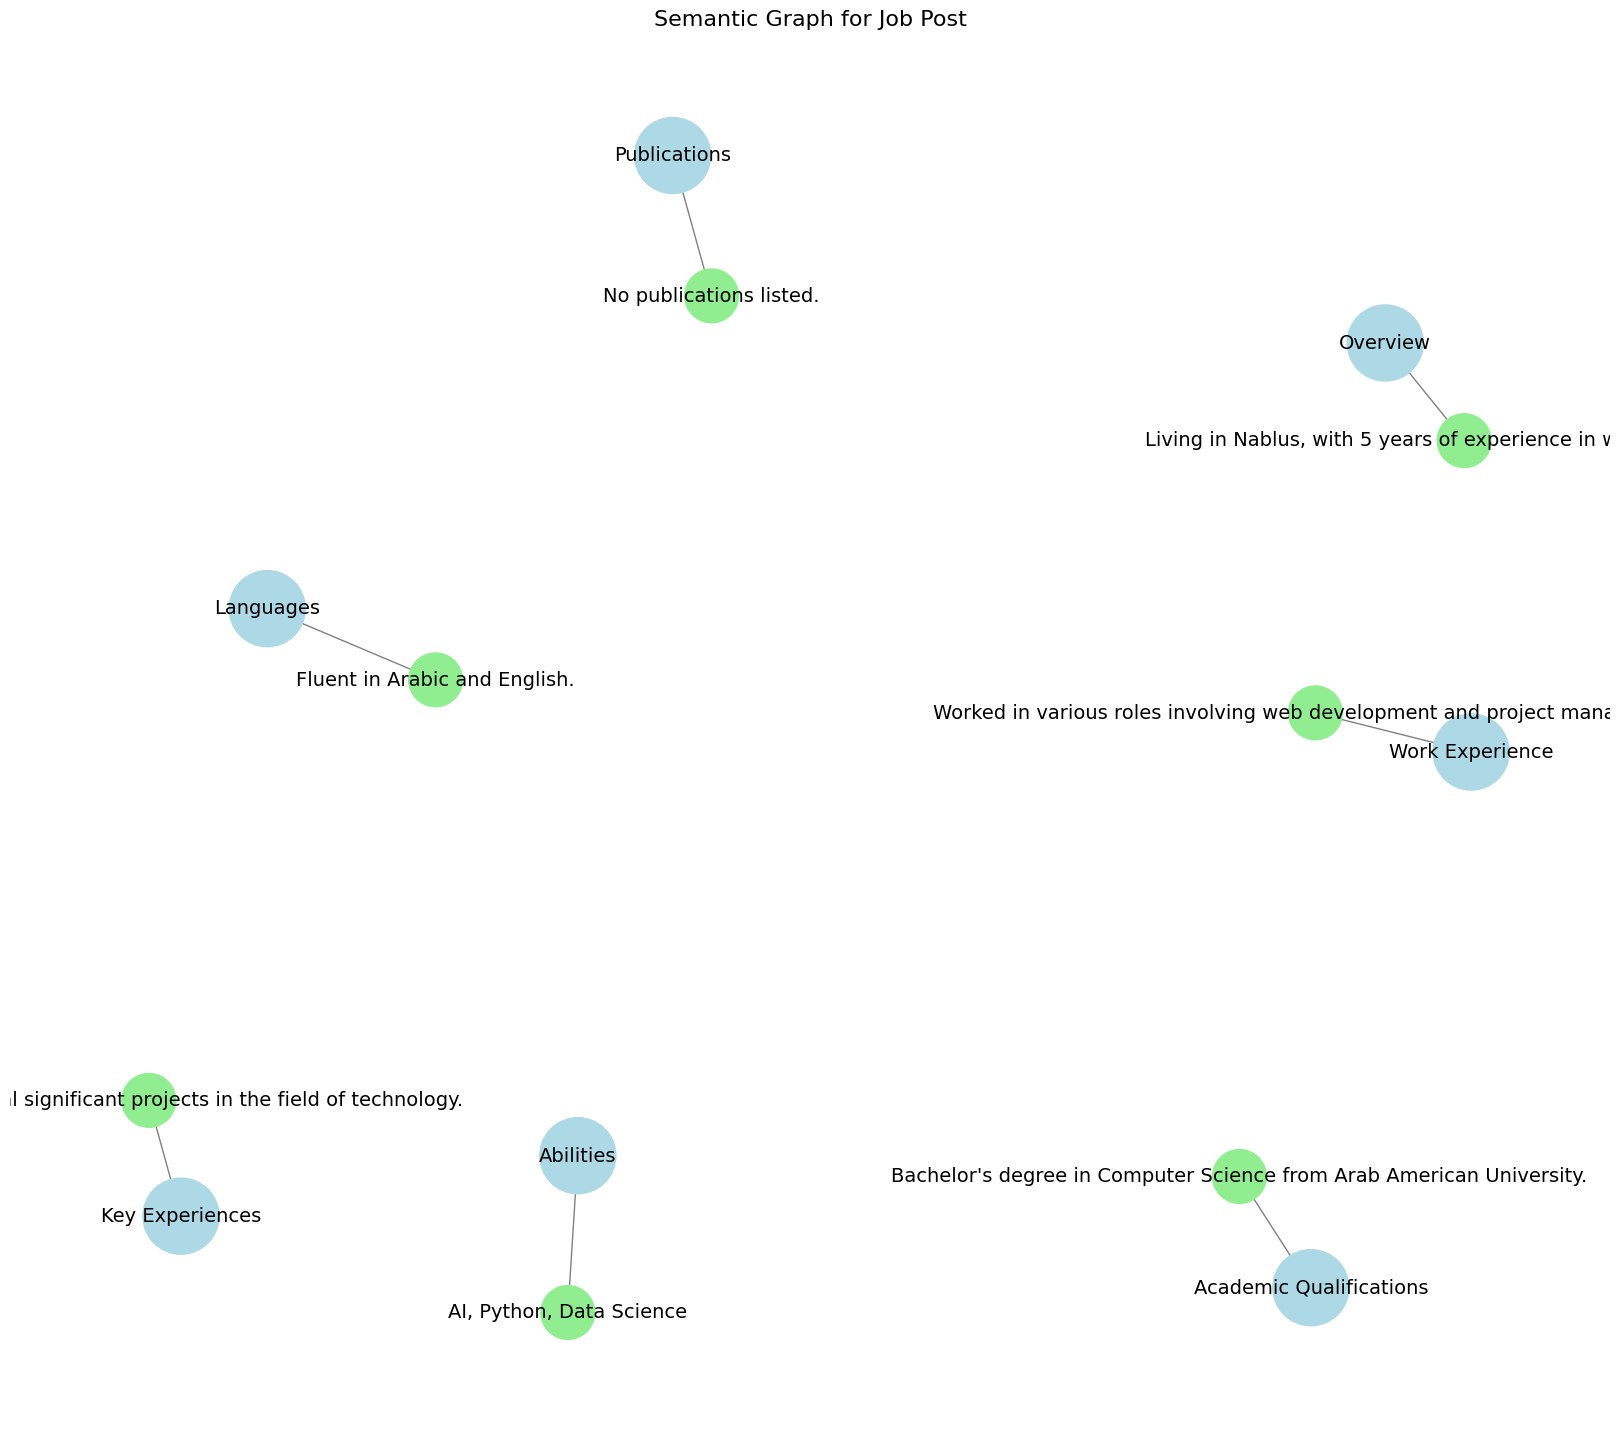

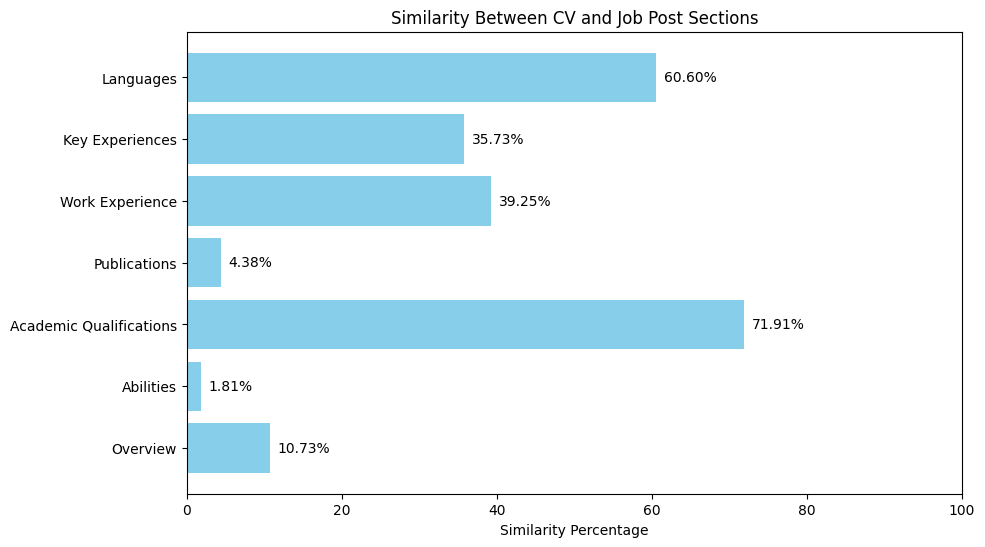

In [ ]:
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import matplotlib.pyplot as plt
import networkx as nx

# Define keywords for each section with new header categories
keywords = {
    "Overview": ["About Me", "My Project", "Contact"],
    "Abilities": ["Skills","Key Experiences"],
    "Academic Qualifications": ["Academic Qualifications"],
    "Publications": ["Publications"],
    "Work Experience": ["Work Experience"],
    "Key Experiences": ["Key Experiences"],
    "Languages": ["Languages"]
}

# Function to summarize text
def summarize_text(text):
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    summary = summarizer(text, max_length=150, min_length=30, do_sample=False)
    return summary[0]['summary_text']

# Function to segment text based on headers
def segment_text(text, headers):
    segments = {}
    current_header = None
    segment_text = ""

    lines = text.split('\n')
    for line in lines:
        header_found = any(header in line for header in headers)
        if header_found:
            if current_header:
                segments[current_header] = segment_text.strip()
            current_header = next(header for header in headers if header in line)
            segment_text = ""
        segment_text += line + "\n"

    if current_header:
        segments[current_header] = segment_text.strip()

    return segments

# Function to calculate similarity percentage using TF-IDF and cosine similarity
def similarity_percentage(a, b):
    # Generate embeddings for the text segments
    embeddings_a = model.encode(a, convert_to_tensor=True)
    embeddings_b = model.encode(b, convert_to_tensor=True)

    # Calculate cosine similarity between the embeddings
    similarity = util.cos_sim(embeddings_a, embeddings_b).item()

    # Convert similarity to percentage
    return similarity * 100

# Function to compare job post keywords with CV sections
def compare_keywords_with_cv(cv_segments, job_post_keywords):
    comparison_summary = {}

    for category, job_post_text in job_post_keywords.items():
        cv_text = cv_segments.get(category, "")
        # Calculate similarity percentage
        percentage = similarity_percentage(cv_text, job_post_text)

        # Add to the summary
        comparison_summary[category] = {
            "CV": cv_text.strip(),
            "Job Post": job_post_text.strip(),
            "Percentage Match": round(percentage, 2)  # Rounded to two decimal places
        }

    return comparison_summary

# Function to summarize the comparison
def summarize_comparison(comparison_summary):
    summary = "Summary of CV and Job Post Keyword Comparison:\n\n"
    for category, content in comparison_summary.items():
        summary += f" {category}:\n"
        summary += f"CV:\n{content['CV']}\n\n"
        summary += f"Job Post:\n{content['Job Post']}\n\n"
        summary += f"Percentage Match: {content['Percentage Match']}%\n\n"

    return summary

# Function to create a semantic graph
def create_semantic_graph(categorized_segments, title):
    graph = nx.Graph()

    for header, content in categorized_segments.items():
        graph.add_node(header, type='main', label=header)

        for detail in content.split('\n'):
            if detail.strip():
                detail_node = f"{header} - {detail[:30]}..."
                graph.add_node(detail_node, type='detail', label=detail.strip())
                graph.add_edge(header, detail_node)

    pos = nx.spring_layout(graph, k=0.5, iterations=50)
    node_types = nx.get_node_attributes(graph, 'type')
    labels = nx.get_node_attributes(graph, 'label')

    color_map = {'main': 'lightblue', 'detail': 'lightgreen'}
    node_colors = [color_map[node_types.get(node, 'main')] for node in graph.nodes()]
    node_sizes = [3000 if node_types.get(node) == 'main' else 1500 for node in graph.nodes()]
    font_sizes = [14 if node_types.get(node) == 'main' else 12 for node in graph.nodes()]

    plt.figure(figsize=(16, 14))
    nx.draw(graph, pos, with_labels=True, labels=labels, node_color=node_colors, edge_color='gray', node_size=node_sizes, font_size=14, font_color='black')
    plt.title(f'Semantic Graph for {title}', fontsize=16)
    plt.show()

    return graph

# Function to plot similarity percentages as a bar chart
def plot_similarity_chart(comparison_summary):
    categories = list(comparison_summary.keys())
    percentages = [content["Percentage Match"] for content in comparison_summary.values()]

    plt.figure(figsize=(10, 6))
    plt.barh(categories, percentages, color='skyblue')
    plt.xlabel('Similarity Percentage')
    plt.title('Similarity Between CV and Job Post Sections')
    plt.xlim(0, 100)

    for index, value in enumerate(percentages):
        plt.text(value + 1, index, f'{value:.2f}%', va='center', fontsize=10)

    plt.show()

# Example job post data with new headers
job_post_keywords = {
    "Overview": "Living in Nablus, with 5 years of experience in web development.",
    "Abilities": "AI, Python, Data Science",
    "Academic Qualifications": "Bachelor's degree in Computer Science from Arab American University.",
    "Publications": "No publications listed.",
    "Work Experience": "Worked in various roles involving web development and project management.",
    "Key Experiences": "Completed several significant projects in the field of technology.",
    "Languages": "Fluent in Arabic and English."
}

# Example CV text
cv_text = """
Sanad Ahmad      Mobile: 0594 55 80 90
Email: sanad.ahmed2000@gmail.com

Address: Jaba' – Jenin – Palestine
Jobs:  IT Project Manager | AI Trainer

Academic Qualifications
Degree	Track	Institution	Year	GPA
Tawjihi	Scientific	Secondary School	2007	3.7
Bachelor	IT: Computer Science	Arab American University	2011	3.76
Master	Computer Science: Machine Learning	Arab American University	2021	4.00
Ph.D. Candidate	Artificial Intelligence:
Natural Language Processing - NLP	Birzeit University	2024	3.7

Publications
1.	NLU-STR at SemEval-2024 Task 1: Generative-based Augmentation and Encoder-based Scoring for Semantic Textual Relatedness
2.	Context-Gloss Augmentation for Improving Arabic Target Sense Verification
3.	Salma: Arabic sense-annotated corpus and wsd benchmarks
4.	Classification and Prediction of Low-Density Lipoprotein Cholesterol LDL-C …
5.	Detecting Network Traffic-based Attacks Using ANNs

Work Experience
1.	Dimensions InfoTech – Palestine (http://dimensions-infotech.com)
A.	Eclaims and Integration Specialist Jan 2018 – Now
2.	Dimensions Healthcare – Dubai (http://www.dimensions-healthcare.com/)
A.	Software Development (4 years) & Team Lead (2 years): Jan 2012 - Jan 2018
3.	Arab American University – Palestine (https://www.aaup.edu/)
A.	Teaching Assistant: Jan 2011 - Jan 2012
4.	Robotics & AI – Palestine
A.	Trainer (Workshops & Training Programs): Jan 2021 - Now

Key Experiences
Business 	Technical
Markets: Palestine, Dubai, and Saudi Arabia	Technology: ASP.Net (Forms), WCF, EF6
IT Project Management & Team Lead	Robotics, AI, & NLP: Python + Models
System Analysis	Web App\Service Development
Technical Consultation	Code Management: GitLab, VSTS, SVN
Clients Relationships	Help Desk & Support
Business Development	Research & Teaching Assistance

Languages Mother tongue Arabic, & Very Good English
"""

# Process the CV text and compare with job post keywords
cv_segments = segment_text(cv_text, [header for headers in keywords.values() for header in headers])
comparison_summary = compare_keywords_with_cv(cv_segments, job_post_keywords)
summary_comparison = summarize_comparison(comparison_summary)

print("Summary:")
print(summary_comparison)

# Generate and visualize the semantic graphs for CV
create_semantic_graph(cv_segments, "CV")

# Generate and visualize the semantic graphs for Job Post
create_semantic_graph(job_post_keywords, "Job Post")

# Plot the similarity chart
plot_similarity_chart(comparison_summary)




BERT Similarity

In [ ]:
!pip install sentence-transformers


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load the Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to calculate similarity percentage using Sentence-BERT
def similarity_percentage(a, b):
    # Generate embeddings for the text segments
    embeddings_a = model.encode(a, convert_to_tensor=True)
    embeddings_b = model.encode(b, convert_to_tensor=True)

    # Calculate cosine similarity between the embeddings
    similarity = util.cos_sim(embeddings_a, embeddings_b).item()
    # Convert similarity to percentage
    return similarity * 100

text1 = "C++, JavaScript, HTML, Java, SQL"
text2 = "Python, Machine Learning, Data Science"
print(similarity_percentage(text1, text2))


26.719191670417786


MeanSqureError

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load the Sentence-BERT model
try:
    model = SentenceTransformer('all-MiniLM-L6-v2')
except Exception as e:
    print(f"Error loading model: {e}")
    raise

# Function to calculate similarity percentage using Sentence-BERT
def similarity_percentage(a, b):
    try:
        # Generate embeddings for the text segments
        embeddings_a = model.encode(a, convert_to_tensor=True)
        embeddings_b = model.encode(b, convert_to_tensor=True)

        # Calculate cosine similarity between the embeddings
        similarity = util.cos_sim(embeddings_a, embeddings_b).item()

        # Convert similarity to percentage
        return similarity * 100
    except Exception as e:
        print(f"Error calculating similarity: {e}")
        return 0.0

# Example usage of the similarity_percentage function
text1 = "Python, C++, Machine Learning"
text2 = "SQL, CSS, AI, JavaScript, Data Science"

percentage = similarity_percentage(text1, text2)
print(f"Similarity percentage: {percentage:.2f}%")


Similarity percentage: 34.43%


 RoBERTa

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load the RoBERTa model
model = SentenceTransformer('stsb-roberta-base')

def similarity_percentage(a, b):
    embeddings_a = model.encode(a, convert_to_tensor=True)
    embeddings_b = model.encode(b, convert_to_tensor=True)
    similarity = util.cos_sim(embeddings_a, embeddings_b).item()
    return similarity * 100

# Example usage
text1 = "Python, C++, Machine Learning"
text2 = "SQL, CSS, AI, JavaScript, Data Science"
percentage = similarity_percentage(text1, text2)
print(f"Similarity percentage: {percentage:.2f}%")


Similarity percentage: 37.38%


DistilBERT

In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load the DistilBERT model
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

def similarity_percentage(a, b):
    embeddings_a = model.encode(a, convert_to_tensor=True)
    embeddings_b = model.encode(b, convert_to_tensor=True)
    similarity = util.cos_sim(embeddings_a, embeddings_b).item()
    return similarity * 100

# Example usage
text1 = "SQL, Machine Learning, C++"
text2 = "Java, AI, Python, Data Science, Machine Learning"
percentage = similarity_percentage(text1, text2)
print(f"Similarity percentage: {percentage:.2f}%")


Similarity percentage: 71.03%


Universal Sentence Encoder (USE)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load the Universal Sentence Encoder
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def similarity_percentage(a, b):
    embeddings = model([a, b])
    similarity = np.inner(embeddings[0], embeddings[1])
    return similarity * 100

# Example usage
text1 = "SQL, Machine Learning, C++"
text2 = "Java, AI, Python, Data Science, Machine Learning"
percentage = similarity_percentage(text1, text2)
print(f"Similarity percentage: {percentage:.2f}%")


Similarity percentage: 63.29%


calculate the Mean Squared Error (MSE) for different sentence similarity models(18-08-2024)

In [ ]:
!pip install sentence-transformers pandas

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tqdm.autonotebook')


# Load CSV file
file_path = '/content/Job Datsset.csv'
df = pd.read_csv(file_path)

# Assuming your CSV file has columns 'sentence1', 'sentence2', and 'true_similarity'
sentences1 = df['User_Skills'].tolist()
sentences2 = df['Job_Requirements'].tolist()
true_similarities = df['Match_Score'].tolist()

# Define models
models = {
    'BERT': SentenceTransformer('bert-base-nli-mean-tokens'),
    'RoBERTa': SentenceTransformer('roberta-large-nli-stsb-mean-tokens'),
    'DistilBERT': SentenceTransformer('distilbert-base-nli-stsb-mean-tokens'),
    'USE': SentenceTransformer('stsb-roberta-base-v2')  # Example for USE; use appropriate model if different
}

# Function to calculate similarity scores in batches
def calculate_similarity(model, s1, s2, batch_size=32):
    similarities = []
    for i in range(0, len(s1), batch_size):
        batch_s1 = s1[i:i + batch_size]
        batch_s2 = s2[i:i + batch_size]
        embeddings1 = model.encode(batch_s1, convert_to_tensor=True)
        embeddings2 = model.encode(batch_s2, convert_to_tensor=True)
        cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
        similarities.extend(cosine_scores.diagonal().tolist())  # Extract diagonal (pairwise similarities)
    return similarities

# Calculate MSE for each model
mse_scores = {}

for model_name, model in models.items():
    print(f"Calculating similarities using {model_name}...")
    predicted_similarities = calculate_similarity(model, sentences1, sentences2, batch_size=16)
    mse = mean_squared_error(true_similarities, predicted_similarities)
    mse_scores[model_name] = mse
    print(f"MSE for {model_name}: {mse}")

# Print all MSE scores
print("\nMSE Scores for All Models:")
for model_name, mse in mse_scores.items():
    print(f"{model_name}: {mse}")


Calculating similarities using BERT...
MSE for BERT: 0.19252387307350963
Calculating similarities using RoBERTa...
MSE for RoBERTa: 0.11966189641945937
Calculating similarities using DistilBERT...
MSE for DistilBERT: 0.13457805800137182
Calculating similarities using USE...
MSE for USE: 0.11389851494895836

MSE Scores for All Models:
BERT: 0.19252387307350963
RoBERTa: 0.11966189641945937
DistilBERT: 0.13457805800137182
USE: 0.11389851494895836
